<h3>Final Project Code: NB Supervised + Semisupervised for Emotions Analysis along with HDP-LDA for Topic Modelling. </h3>

<h5>Loading Data and Imports </h5>

In [1]:
#import modules
import pandas as pd
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import sys
import spacy
import matplotlib.pyplot as plt
from plotnine import ggplot, aes,labs, theme_bw, scale_x_continuous, \
                    geom_bar,lims, geom_text
from pyvis.network import Network
import networkx as nx
import nltk
from tqdm import tqdm
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import tomotopy as tp
from sklearn.metrics import v_measure_score
import seaborn as sns
from sklearn.metrics import f1_score


In [2]:
# import data files for both models
train_set = pd.read_csv("./tests/data/tidy_text_data.csv")
train_set.head()
train_set = train_set[:1250]

extra_paragraphs = pd.read_csv("./tests/data/tidy_text_data.csv")
extra_paragraphs = extra_paragraphs[:1250]

train = pd.read_csv("./tests/data/train.txt", sep=";")
train.columns = ["text","sentiment"]
test = pd.read_csv("./tests/data/test.txt", sep=";")
test.columns = ["text","sentiment"]

In [3]:
# Helper functions
def unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

# lemmatize entries
def lemmatize(word_list, ptags):
    '''Lemmatizes words based on allowed postags, input format is list of sublists 
       with strings'''
    spC = spacy.load('en_core_web_sm')
    lem_lists =[]
    for vec in word_list:
        sentence = spC(" ".join(vec))
        lem_lists.append([token.lemma_ for token in sentence if token.pos_ in ptags])
    return lem_lists

# Delete null rows post lemmatized
def clean_nonentry_lemmatized(df):
    list_to_remove = []
    for i, word_list in enumerate(df):
        if len(word_list) == 0:
            list_to_remove.append(i)
    list_to_remove.reverse()
    for index in list_to_remove:
        df.pop(index)
    return df

# Function to visualize clusters and their predictions
def breakdown_clusters_by_ground_truth(y_true, cluster_labels, display=True) :
    assert len(y_true) == len(cluster_labels), "Length of Target and cluster labels don't match"
    df = pd.DataFrame({'true topics' : y_true, 'predictions' : cluster_labels})
    counts = df.groupby(['true topics', 'predictions']).size().reset_index().rename(columns={0:'count'})
    if display :
        sns.barplot(x="true topics", y="count", hue="predictions", data=counts)
    return v_measure_score(y_true, cluster_labels)

# Evaluate coherence scores for HDP-LDA models
def eval_coherence(topics_dict, word_list, coherence_type='c_v'):
    # Build gensim objects
    vocab = corpora.Dictionary(word_list)
    corpus = [vocab.doc2bow(words) for words in word_list]
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens=[]
        for w, p in tups:
            topic_tokens.append(w)
        topic_list.append(topic_tokens)
    # Build Coherence model
    cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab, texts=word_list, 
                    coherence=coherence_type)
    score = cm.get_coherence()
    return score

<h4> Preprocessing Data for Models </h4>

In [4]:
# Data Processing for Emotions NB
train_text = train.text
extra_paragraphs_text = extra_paragraphs.text_new
vectorizer = CountVectorizer(max_features=5000, min_df=3, binary=True, 
                             stop_words="english")
X_supervised = vectorizer.fit_transform(train_text)
X_unsupervised = vectorizer.transform(extra_paragraphs_text)
y_topic_train = train['sentiment']
y_topic_test = test['sentiment']
X_supervised.shape, X_unsupervised.shape
X = vectorizer.fit_transform(train_text)
X_test = vectorizer.transform(test.text)
test_sentiment = test.sentiment
combined_X = np.concatenate((X_supervised.toarray(), X_unsupervised.toarray()), axis = 0)
mask = np.arange(X_supervised.shape[0])
topics = unique(train['sentiment'])
y_train = np.array([topics.index(k) for k in train['sentiment']],dtype=int)
combined_Y = np.concatenate((y_train, np.zeros(X_unsupervised.shape[0], dtype=int)), axis=0)
y_test = np.array([topics.index(k) for k in test_sentiment],dtype=int)

print("Number of emotions: " + str(len(unique(combined_Y))))
n, d = X.shape
k = 6
X.shape
temp = np.zeros((len(y_train),k))
for i in range(n):
    temp[i,y_train[i]] = 1


Number of emotions: 6


In [5]:
# Data Processing for HDP-LDA topic modelling
# Remove stop words, minimum word length = 3, create bigrams, lemmatize words. 
nltk.download('stopwords', quiet=True)
st_words = stopwords.words('english')
extra_stops=['from','subject','re', 'edu','use']
st_words.extend(extra_stops)
doc_list = train_set.text_new.values.tolist()
word_list = [simple_preprocess(str(txt), deacc=True, min_len=3) for txt in doc_list]
bigram = Phrases(word_list, min_count=5, threshold=100) # use original wordlist to build model
bigram_model = Phraser(bigram)
word_list_nostops = [[word for word in txt if word not in st_words] for txt in word_list]
word_bigrams = [bigram_model[w_vec] for w_vec in word_list_nostops]
word_list_lemmatized = lemmatize(word_bigrams, ptags=['NOUN','VERB','ADV','ADJ'])

# Clean data
word_list_lemmatized = clean_nonentry_lemmatized(word_list_lemmatized)
print(word_list_lemmatized[0][:7],len(word_list_lemmatized[0]),len(word_list_lemmatized) )

['lean', 'empty', 'guard', 'desk', 'hear', 'footstep', 'straighten'] 15 1248


<h4>NB Supervised + Semisupervised Training for Emotions Analysis </h4>

In [6]:
class SoftMultinomialNB(MultinomialNB):
    # Note y = numpy array of size n x k containing 
    # for each example n, the probability of it belonging to class k.
    def fit(self, X, y, sample_weight=None):        
      _, n_features = X.shape
      self.n_features_in_ = n_features 
      Y = y
      self.classes_ = np.arange(Y.shape[1])
      
      if sample_weight is not None:
          Y = Y.astype(np.float64, copy=False)
          sample_weight = np.asarray(sample_weight)
          sample_weight = np.atleast_2d(sample_weight)
      class_prior = self.class_prior
      # Count raw events from data before updating the class log prior
      # and feature log probas
      n_effective_classes = Y.shape[1]
      self._init_counters(n_effective_classes, n_features)
      self._count(X, Y)
      alpha = self._check_alpha()
      self._update_feature_log_prob(alpha)
      self._update_class_log_prior(class_prior=class_prior)
      return self

# Semi supervised EM NB with soft and hard capabilities.
def semisupervised_EM(init_model,k, X, y_true, mask, max_iters=200, soft=False,
                      return_model=False):
    '''
    Implements semi-supervised Hard or Soft EM model.
        - init_model is a function for initializing the SoftMultinomialNB model
            (hint: you are going to want to use this parameter later in the
             homework to initialize in a different model)
        - X is an (n x d) numpy array
        - y_true - 0-6 class labels defined previously.
        - mask - an array of size n containing True or False indicating if you
            are to use the true labels of that example or not.
        - soft - a boolean variable, which if true, performs soft EM and
            otherwise performs hard EM
        - return_model - specifies whether or not to return the NB classifier
    '''
    X.shape
    temp = np.zeros((len(y_true),k))
    for i in range(temp.shape[0]):
        temp[i,y_true[i]] = 1
    # model init
    m = init_model()
    x_train = X[mask]
    # y_train = y_true[mask]
    y_train_mat = temp[mask]
    #fit training with masked train targets
    m.fit(x_train, y_train_mat)
    y_hat = None
    for _ in tqdm(range(max_iters)):
        # E Step: predict the latent variables (y_hat) using the model
        newy_hat = m.predict_proba(X)
        if not soft:
            for i_soft in range(len(newy_hat)):
                bestindex = np.argmax(newy_hat[i_soft])
                newy_hat[i_soft,:] = 0
                newy_hat[i_soft, bestindex] = 1
        # converged, return model
        if (newy_hat == y_hat).all():
            if return_model:
                return newy_hat, m
            else: 
                return newy_hat
        y_hat = newy_hat
        #M Step: retrain the model using the latent variables
        y_hat[mask] = y_train_mat
        m.fit(X, y_hat)
    y_hat = m.predict(X)
    if return_model:
        return y_hat, m
    else:
        return y_hat

<h4> NB Supervised + Semisupervised Model Training for Emotions Analysis </h4>

In [7]:
# train supervised, semi supervised softs and hards models
m_spvised = SoftMultinomialNB(fit_prior=False).fit(X, temp)
y_hat_spvised = m_spvised.predict(X_test)
yhat_soft, m_soft = semisupervised_EM(lambda: SoftMultinomialNB(), 6, combined_X, combined_Y, mask, return_model=True, soft=True)
yhat_hard, m_hard = semisupervised_EM(lambda: SoftMultinomialNB(), 6, combined_X, combined_Y, mask, return_model=True)

100%|██████████| 200/200 [02:37<00:00,  1.27it/s]


<h4>NB Supervised + Semisupervised Model Evaluation for Emotions Analysis </h4>

In [8]:
# V-measure and f1 scores for train sets for both Hard & Soft-EM models
prediction_train = m_soft.predict(X_supervised)
train_eval = v_measure_score(train.sentiment, prediction_train)
print(f'The f1 score of fully trained Soft-EM model = {f1_score(y_train, prediction_train,average="macro")}')
print(f'The v-measure of fully trained Soft-EM model = ' + str(train_eval))
print()
prediction_train_hard = m_hard.predict(X_supervised)
train_eval = v_measure_score(train.sentiment, prediction_train_hard)
print(f'The f1 score of fully trained Hard-EM model = {f1_score(y_train, prediction_train_hard,average="macro")}')
print(f'The v-measure of fully trained Hard-EM model = ' + str(train_eval))


The f1 score of fully trained Soft-EM model = 0.8880947429311116
The v-measure of fully trained Soft-EM model = 0.7669671920035445

The f1 score of fully trained Hard-EM model = 0.8937319788053512
The v-measure of fully trained Hard-EM model = 0.777863080032788


The f1 score of fully trained model = 0.7329266095376865
The v-measure of fully trained model = 0.5700987286997196


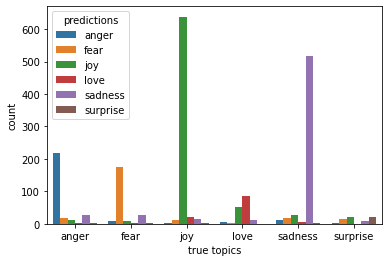

In [9]:
# Soft-EM Model Results on semi-supervised test set
prediction_test_soft = m_soft.predict(X_test)
predictions_emotions_soft = [topics[i] for i in prediction_test_soft]
test_eval_soft = lambda cluster_labels, d=True: breakdown_clusters_by_ground_truth(test_sentiment, predictions_emotions_soft, d)
print(f'The f1 score of fully trained model = {f1_score(y_test, prediction_test_soft,average="macro")}')
print(f'The v-measure of fully trained model = {test_eval_soft(prediction_test_soft, d=True)}')

The f1 score of fully trained model = 0.7429693433056285
The v-measure of fully trained model = 0.5893649307648582


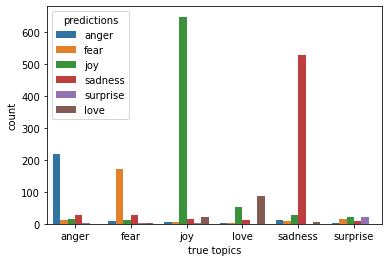

In [10]:
# Hard-EM Model Results on semi-supervised test set
prediction_test_hard = m_hard.predict(X_test)
predictions_emotions_hard = [topics[i] for i in prediction_test_hard]
test_eval_hard = lambda cluster_labels, d=True: breakdown_clusters_by_ground_truth(test.sentiment, predictions_emotions_hard, d)
print(f'The f1 score of fully trained model = {f1_score(y_test, prediction_test_hard,average="macro")}')
print(f'The v-measure of fully trained model = {test_eval_hard(prediction_test_hard, d=True)}')

The f1 score of fully trained model = 0.7806264577724985
The v-measure of fully trained model = 0.5971668515814397


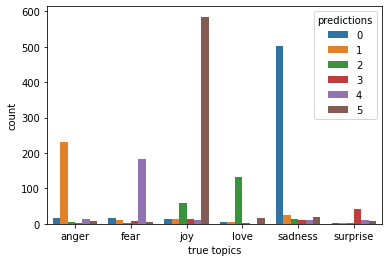

In [11]:
# Results for supervised model on test set
train_eval = lambda cluster_labels, d=True: breakdown_clusters_by_ground_truth(y_topic_train, cluster_labels, d)
test_eval = lambda cluster_labels, d=True: breakdown_clusters_by_ground_truth(y_topic_test, cluster_labels, d)

print(f'The f1 score of fully trained model = {f1_score(y_hat_spvised, y_test,average="macro")}')
print(f'The v-measure of fully trained model = {test_eval(y_hat_spvised, d=True)}')

<h4> HDP-LDA Model Training for Topic Modelling </h4>

In [12]:
def train_HDPmodel(hdp, word_list, mcmc_iter, burn_in=100, quiet=False):
    '''Wrapper function to train tomotopy HDP Model object
    
    *** Inputs**
    hdp: obj -> initialized HDPModel model
    word_list: list -> lemmatized word list of lists
    mcmc_iter : int -> number of iterations to train the model
    burn_in: int -> MC burn in iterations
    quiet: bool -> flag whether to print iteration LL and Topics, if True nothing prints out
    
    ** Returns**
    hdp: trained HDP Model 
    '''
    # Add docs to train
    for vec in word_list:
        hdp.add_doc(vec)
        
    # Initiate MCMC burn-in 
    hdp.burn_in = 100
    hdp.train(0)
    print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs, ', Num words:', hdp.num_words)
    print('Removed top words:', hdp.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)

    # Train model
    step=round(mcmc_iter*0.10)
    for i in range(0, mcmc_iter, step):
        hdp.train(step, workers=3)
        if not quiet:
            print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))
    print("Done\n")  
    return hdp
    
        
def get_hdp_topics(hdp, top_n=10):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    hdp:obj -> HDPModel trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        topic_wp =[]
        for word, prob in hdp.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics

In [13]:
tw_list = [tp.TermWeight.ONE, # all terms weighted equally
           tp.TermWeight.PMI, # Pointwise Mutual Information term weighting
           tp.TermWeight.IDF] # down-weights high frequency terms, upweights low freq ones

tw_names = ['one', 'pmi', 'idf']
model_topics =[]

# train trainning data with all three tomotopy models
for i, term_weight in enumerate(tw_list):
    hdp = tp.HDPModel(tw=term_weight, min_cf=10, rm_top=10, gamma=1, alpha=0.1,
                     initial_k=50, seed=99999)
    print("Model " + tw_names[i] )
    hdp = train_HDPmodel(hdp, word_list_lemmatized, mcmc_iter=2000)
    # save models
    hdp.save('./tests/models/hdp_model_'+tw_names[i]+".bin")
    model_topics.append(get_hdp_topics(hdp, top_n=10))

Training...


Model one
Num docs: 1248 , Vocab size: 412 , Num words: 10135
Removed top words: ['know', 'time', 'make', 'day', 'see', 'life', 'come', 'take', 'look', 'think']
Iteration: 0	Log-likelihood: -6.73474109804448	Num. of topics: 575
Iteration: 200	Log-likelihood: -6.713518385235523	Num. of topics: 580
Iteration: 400	Log-likelihood: -6.690679206645836	Num. of topics: 560
Iteration: 600	Log-likelihood: -6.709285356402103	Num. of topics: 533
Iteration: 800	Log-likelihood: -6.685690065175956	Num. of topics: 550
Iteration: 1000	Log-likelihood: -6.708384910827208	Num. of topics: 530
Iteration: 1200	Log-likelihood: -6.708187424519053	Num. of topics: 536


Training...


Iteration: 1400	Log-likelihood: -6.698106772686733	Num. of topics: 522
Iteration: 1600	Log-likelihood: -6.70435556549125	Num. of topics: 522
Iteration: 1800	Log-likelihood: -6.668683529817593	Num. of topics: 539
Done

Model pmi
Num docs: 1248 , Vocab size: 412 , Num words: 10135
Removed top words: ['know', 'time', 'make', 'day', 'see', 'life', 'come', 'take', 'look', 'think']
Iteration: 0	Log-likelihood: -3.9944996409467355	Num. of topics: 717
Iteration: 200	Log-likelihood: -3.9301702695852456	Num. of topics: 740
Iteration: 400	Log-likelihood: -3.932655440670315	Num. of topics: 739
Iteration: 600	Log-likelihood: -3.947396883874036	Num. of topics: 740
Iteration: 800	Log-likelihood: -3.943884515073624	Num. of topics: 752
Iteration: 1000	Log-likelihood: -3.9342734380247775	Num. of topics: 732
Iteration: 1200	Log-likelihood: -3.930298767031224	Num. of topics: 743
Iteration: 1400	Log-likelihood: -3.9503558528836376	Num. of topics: 715
Iteration: 1600	Log-likelihood: -3.930631792167155	Num. 

Training...


Iteration: 1800	Log-likelihood: -3.92097575454892	Num. of topics: 760
Done

Model idf
Num docs: 1248 , Vocab size: 412 , Num words: 10135
Removed top words: ['know', 'time', 'make', 'day', 'see', 'life', 'come', 'take', 'look', 'think']
Iteration: 0	Log-likelihood: -5.6514180705924995	Num. of topics: 82
Iteration: 200	Log-likelihood: -5.671473896390128	Num. of topics: 78
Iteration: 400	Log-likelihood: -5.649922053516658	Num. of topics: 85
Iteration: 600	Log-likelihood: -5.679379745710983	Num. of topics: 75
Iteration: 800	Log-likelihood: -5.6535223795325455	Num. of topics: 83
Iteration: 1000	Log-likelihood: -5.670151678500549	Num. of topics: 79
Iteration: 1200	Log-likelihood: -5.654663722787702	Num. of topics: 78
Iteration: 1400	Log-likelihood: -5.715210963097346	Num. of topics: 70
Iteration: 1600	Log-likelihood: -5.668276510456224	Num. of topics: 77
Iteration: 1800	Log-likelihood: -5.669398662882149	Num. of topics: 78
Done



<h4> HDP-LDA Model Evaluation for Topic Modelling </h4>

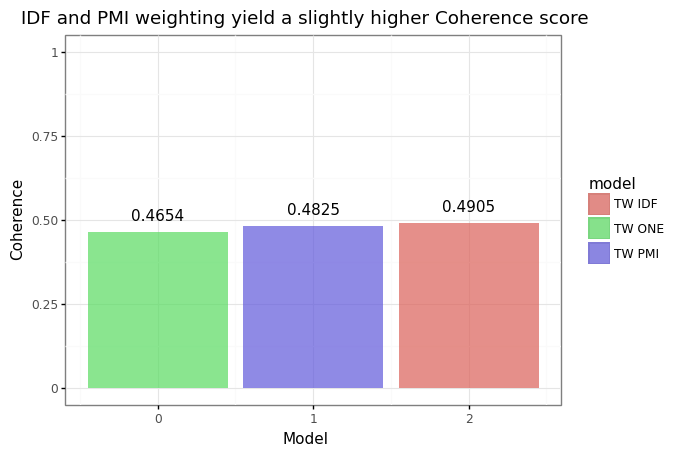

<ggplot: (105769664386)>

In [14]:
coherence_scores = np.zeros(len(model_topics))

for i, t in enumerate(model_topics):
    coherence_scores[i] = eval_coherence(t, word_list_lemmatized)
    
# Plotting
df_coherence = pd.DataFrame(coherence_scores).T
df_coherence.columns = ["TW ONE", "TW PMI", "TW IDF"]
df_coherence= df_coherence.melt(var_name="model").round(4)
df_coherence.reset_index(inplace=True)

(ggplot(df_coherence) +
 geom_bar(aes(x='index', y="value", fill="model"), 
          stat="identity", alpha=0.7) +
 geom_text(aes(x="index",y=df_coherence.value.values +0.05, label="value")) +
 theme_bw() +
 lims(y=(0,1)) +
 labs(y="Coherence", x="Model", title="IDF and PMI weighting yield a slightly higher Coherence score") 
)

In [16]:
# Load models
hdp_one = tp.HDPModel.load("./tests/models/hdp_model_one.bin")
hdp_pmi = tp.HDPModel.load("./tests/models/hdp_model_pmi.bin")
hdp_idf = tp.HDPModel.load("./tests/models/hdp_model_idf.bin")

#Pulling top labels for potential topics and organize in df
topics_df = pd.DataFrame(columns=["entry", "lemmatized", "topic_id", "top_three_labels"])
for i in range(len(word_list_lemmatized)):
    test_doc = word_list_lemmatized[i]
    doc_init = hdp_idf.make_doc(test_doc)
    topic_dist, learned_labels = hdp_idf.infer(doc_init, together=True)
    topic_id = np.array(topic_dist).argmax()
    topic_freqs = dict(hdp_idf.get_topic_words(topic_id))
    topic_keys = list(topic_freqs.keys())
    top_topics = topic_keys[:8]
    to_append = [train_set.text_new[i], test_doc, str(topic_id), str(top_topics)]
    topics_df.loc[i] = to_append
topics_df.head
    

<bound method NDFrame.head of                                                   entry  \
0     James was leaning against the empty guard desk...   
1     There was no clock on the nightstand between t...   
2     Finley should’ve been happier — he should’ve b...   
3     Inside a Belizean cave, you wade deeper into g...   
4     Sophie had forgotten him by then. Not complete...   
...                                                 ...   
1243  He figured a few sticks of dynamite were easie...   
1244  With a single flip of the coin, his life chang...   
1245      Warm beer on a cold day isn't my idea of fun.   
1246  We have never been to Asia, nor have we visite...   
1247  The irony of the situation wasn't lost on anyo...   

                                             lemmatized topic_id  \
0     [lean, empty, guard, desk, hear, footstep, str...        7   
1     [nightstand, bed, analogue, phone, brochure, t...        0   
2     [happy, beam, hardwood, car, job, girlfriend, ...  

In [17]:
#decribe topics_df
def describe_topics_df(df, num):
    if num > df.shape[0]:
        print("document index is larger than df size.")
    else:
        print("Number of entries: " + str(len(df.entry)))
        print("Number of unique topics found in entries: " + str(len(unique(df.topic_id))))
        print()
        print("Example " + str(num) + " found text entry: '" + df.entry[num] + "' belongs to topic number " +  str(df.topic_id[num]) + " with top associted keywords: " + str(df.top_three_labels[num]))

#choose any random number
describe_topics_df(topics_df, 420)

Number of entries: 1248
Number of unique topics found in entries: 51

Example 420 found text entry: 'She had been an angel for coming up on 10 years and in all that time nobody had told her this was possible. The fact that it could ever happen never even entered her mind. Yet there she stood, with the undeniable evidence sitting on the ground before her. Angels could lose their wings.' belongs to topic number 7 with top associted keywords: ['way', 'want', 'go', 'thing', 'get', 'even', 'never', 'say']


<h4> Emotions Analysis on Topics of Random Entries </h4>


In [18]:
text_entries = topics_df.entry
vectorized_text_entries = vectorizer.transform(text_entries)
numerical_predictions = m_hard.predict(vectorized_text_entries) 
emotions_predictions = [topics[i] for i in numerical_predictions]
topics_df["emotions"] = emotions_predictions
topics_df.emotions.head

topics_df.head


<bound method NDFrame.head of                                                   entry  \
0     James was leaning against the empty guard desk...   
1     There was no clock on the nightstand between t...   
2     Finley should’ve been happier — he should’ve b...   
3     Inside a Belizean cave, you wade deeper into g...   
4     Sophie had forgotten him by then. Not complete...   
...                                                 ...   
1243  He figured a few sticks of dynamite were easie...   
1244  With a single flip of the coin, his life chang...   
1245      Warm beer on a cold day isn't my idea of fun.   
1246  We have never been to Asia, nor have we visite...   
1247  The irony of the situation wasn't lost on anyo...   

                                             lemmatized topic_id  \
0     [lean, empty, guard, desk, hear, footstep, str...        7   
1     [nightstand, bed, analogue, phone, brochure, t...        0   
2     [happy, beam, hardwood, car, job, girlfriend, ...  

In [19]:
# Augmenting dataframe with counts for emotions in topics
new_df = topics_df.groupby(['topic_id', 'emotions']).size()

new_df.to_csv("./analysis.csv")
analysis_df = pd.read_csv("./analysis.csv")
analysis_df.columns = ["topic_id", "emotions","count"]
print(analysis_df)

     topic_id  emotions  count
0           0     anger      3
1           0      fear      8
2           0       joy     20
3           0      love      6
4           0   sadness     11
..        ...       ...    ...
98          7   sadness    206
99          7  surprise     55
100        73      love      1
101        73  surprise      1
102         9       joy      2

[103 rows x 3 columns]


In [20]:
# Network graph visualization
G = nx.from_pandas_edgelist(analysis_df,
                            source='topic_id',
                            target='emotions',
                            edge_attr='count')
color_map = ['red' if node == topic_id else 'green' for node in G]        

net = Network(notebook=True)
net.from_nx(G, show_edge_weights=False)
net.show("example.html")